<a href="https://colab.research.google.com/github/kbarone/satellite_deeplearning/blob/main/SatelliteSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler = MinMaxScaler()

In [4]:
!ls -lah '/content/drive/MyDrive/satellite'

total 33K
-rw------- 1 root root  548 May 29  2020  classes.json
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 1'
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 2'
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 3'
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 4'
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 5'
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 6'
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 7'
drwx------ 2 root root 4.0K Mar 17 19:26 'Tile 8'


In [5]:
dataset_root_folder = '/content/drive/MyDrive/satellite'

In [6]:
dataset_name = 'DubaiDataset'

In [7]:
for dirpath, subdir, filenames in os.walk(dataset_root_folder):
  dir_name = dirpath.split(os.path.sep)[-1]
  if dir_name == 'images':
    images = os.listdir(dirpath)
    for i, image_name in enumerate(images):
      print(image_name)

image_part_009.jpg
image_part_005.jpg
image_part_008.jpg
image_part_003.jpg
image_part_001.jpg
image_part_007.jpg
image_part_002.jpg
image_part_006.jpg
image_part_004.jpg
image_part_008.jpg
image_part_005.jpg
image_part_007.jpg
image_part_002.jpg
image_part_001.jpg
image_part_003.jpg
image_part_009.jpg
image_part_004.jpg
image_part_006.jpg
image_part_007.jpg
image_part_004.jpg
image_part_003.jpg
image_part_001.jpg
image_part_002.jpg
image_part_008.jpg
image_part_005.jpg
image_part_006.jpg
image_part_009.jpg
image_part_006.jpg
image_part_001.jpg
image_part_004.jpg
image_part_007.jpg
image_part_008.jpg
image_part_005.jpg
image_part_009.jpg
image_part_003.jpg
image_part_002.jpg
image_part_007.jpg
image_part_004.jpg
image_part_003.jpg
image_part_008.jpg
image_part_006.jpg
image_part_002.jpg
image_part_001.jpg
image_part_009.jpg
image_part_005.jpg
image_part_009.jpg
image_part_003.jpg
image_part_004.jpg
image_part_001.jpg
image_part_002.jpg
image_part_007.jpg
image_part_008.jpg
image_part_0

In [8]:
image_patch_size = 256

In [9]:
image = cv2.imread(f'{dataset_root_folder}/Tile 1/images/image_part_001.jpg', 1)

In [10]:
print(image.shape)
print(image.shape[0]//image_patch_size)
print(image.shape[1]//image_patch_size)

(644, 797, 3)
2
3


In [11]:
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

In [12]:
image_x = image_patches[0,0,:,:]
print(image_x.shape)
minmaxscaler = MinMaxScaler()
print(-1,image_x.shape[-1])
print(image_x.reshape(-1,image_x.shape[-1]).shape)
image_y = minmaxscaler.fit_transform(image_x.reshape(-1,image_x.shape[-1])).reshape(image_x.shape)
print(image_y.shape)

(1, 256, 256, 3)
-1 3
(65536, 3)
(1, 256, 256, 3)


In [13]:
np.squeeze(image_y).shape

(256, 256, 3)

In [14]:
print(type(image))

<class 'numpy.ndarray'>


In [15]:
print(type(Image.fromarray(image)))

<class 'PIL.Image.Image'>


In [16]:
(image.shape[1]//image_patch_size)*image_patch_size

768

In [17]:
image_dataset = []
mask_dataset = []

for typ in ['images', 'masks']:
  if typ == 'images':
    ext = 'jpg'
  else:
    ext = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/Tile {tile_id}/{typ}/image_part_00{image_id}.{ext}', 1)
      if image is not None:
        if typ == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        image = Image.fromarray(image)
        image = image.crop((0,0,size_x,size_y))
        image = np.array(image)
        image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        for i in range(image_patches.shape[0]):
          for j in range(image_patches.shape[1]):
            if typ == 'images':
              ind_patched_img = image_patches[i,j,:,:]
              ind_patched_img = minmaxscaler.fit_transform(ind_patched_img.reshape(-1, ind_patched_img.shape[-1])).reshape(ind_patched_img.shape)
              ind_patched_img = np.squeeze(ind_patched_img)
              image_dataset.append(ind_patched_img)
            else:
              ind_patched_mask = image_patches[i,j,:,:]
              ind_patched_mask = np.squeeze(ind_patched_mask)
              mask_dataset.append(ind_patched_mask)

In [18]:
print(len(mask_dataset))
print(len(image_dataset))

945
945


In [52]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

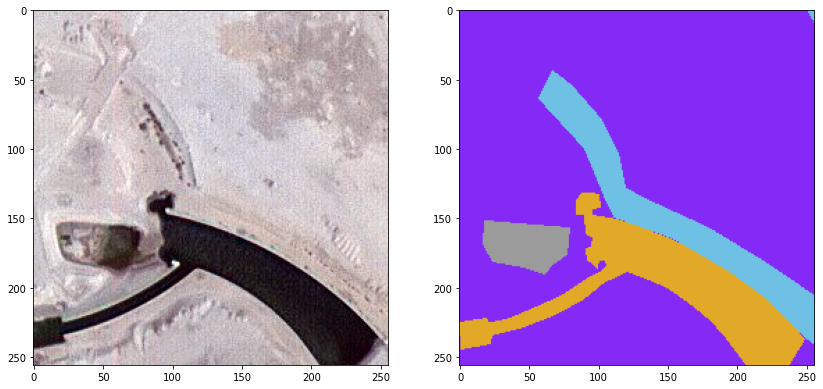

In [56]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [67]:
class_building = '#3C1098'
class_building = class_building.lstrip("#")
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip("#")
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip("#")
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip("#")
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip("#")
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip("#")
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [84]:
label = ind_patched_mask
print(ind_patched_mask.shape)

(256, 256, 3)


In [90]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [91]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [92]:
print(len(labels))

945


In [94]:
labels[5].shape

(256, 256)

In [96]:
labels = np.expand_dims(labels, axis=3)

In [101]:
print("Total unique mask values = {}".format(np.unique(labels)))

Total unique mask values = [0 1 2 3 4 5]


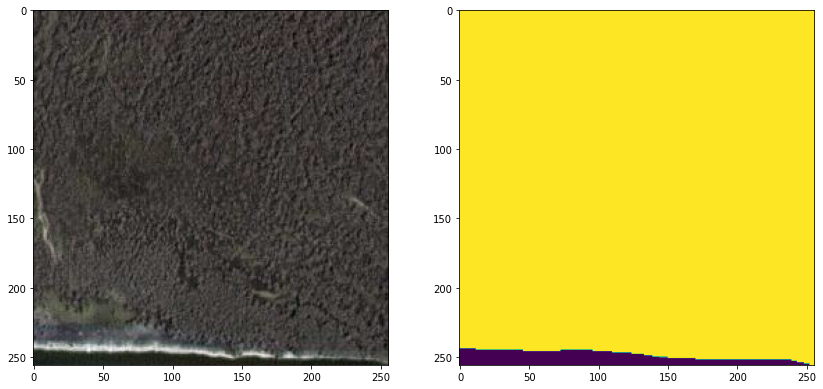

In [114]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id])

In [117]:
total_classes = len(np.unique(labels))

In [122]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

labels_categorical_dataset = np.squeeze(to_categorical(labels, total_classes))

In [123]:
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [124]:
master_training_dataset = image_dataset
master_training_dataset.shape

(945, 256, 256, 3)

In [116]:
from sklearn.model_selection import train_test_split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, 
                 test_size=0.15, random_state=100)

In [127]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)
